# Phase 5: Advanced Algorithms
## Electrical Fault Detection and Classification Project

**Objective:** Test state-of-the-art gradient boosting algorithms to explore potential improvement beyond 99.43% accuracy.

**Current Best:** Random Forest with Domain Features = 99.43%

**Algorithms to Test:**
1. XGBoost - Extreme Gradient Boosting
2. LightGBM - Light Gradient Boosting Machine
3. CatBoost - Categorical Boosting
4. Gradient Boosting - scikit-learn implementation
5. AdaBoost - Adaptive Boosting
6. MLPClassifier - Neural Network (optional)

## 1. Setup and Imports

## Prerequisites: Install OpenMP Library

**XGBoost requires the OpenMP library for parallel processing. Install it based on your operating system:**

### macOS (using Homebrew)
```bash
brew install libomp
```

If you don't have Homebrew installed:
```bash
# Install Homebrew first
/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

# Then install libomp
brew install libomp
```

### Linux (Ubuntu/Debian)
```bash
sudo apt-get update
sudo apt-get install libgomp1
```

### Linux (CentOS/RHEL/Fedora)
```bash
sudo yum install libgomp
```

### Windows

OpenMP is typically included with Visual Studio C++ Build Tools.

**Option 1: Install Visual Studio Build Tools**
1. Download from: https://visualstudio.microsoft.com/downloads/
2. Select "Build Tools for Visual Studio"
3. Install with C++ build tools component

**Option 2: Install via conda (if using Anaconda)**
```bash
conda install -c conda-forge libgomp
```

### Verify Installation

After installation, restart your Jupyter kernel and run:
```python
import xgboost as xgb
print(f'XGBoost version: {xgb.__version__}')
```

If successful, you should see the XGBoost version number without errors.

### Troubleshooting

**If you still get errors on macOS:**
- Ensure Homebrew is up to date: `brew update`
- Try reinstalling: `brew reinstall libomp`
- Restart your terminal/Jupyter kernel

**If you still get errors on Linux:**
- Try: `sudo apt-get install gcc g++ libgomp1`
- Or install full build essentials: `sudo apt-get install build-essential`

**If you still get errors on Windows:**
- Try installing via Anaconda instead of pip
- Use: `conda install -c conda-forge xgboost`

In [2]:
%pip install pandas numpy scikit-learn xgboost lightgbm catboost matplotlib seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import os

# Scikit-learn models
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, ConfusionMatrixDisplay)

# Advanced gradient boosting libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully!')
print(f'XGBoost version: {xgb.__version__}')
print(f'LightGBM version: {lgb.__version__}')

Libraries imported successfully!
XGBoost version: 3.1.2
LightGBM version: 4.6.0


## 2. Create Directory Structure

In [2]:
# Create directories if they don't exist
os.makedirs('../results/advanced_algorithms', exist_ok=True)
os.makedirs('../results/advanced_algorithms/plots', exist_ok=True)
os.makedirs('../results/advanced_algorithms/metrics', exist_ok=True)

# Define output directories
output_dir = '../results/advanced_algorithms'
plots_dir = os.path.join(output_dir, 'plots')
metrics_dir = os.path.join(output_dir, 'metrics')

print('Directory structure created successfully!')
print(f'Output directory: {output_dir}')
print(f'Plots directory: {plots_dir}')
print(f'Metrics directory: {metrics_dir}')

Directory structure created successfully!
Output directory: ../results/advanced_algorithms
Plots directory: ../results/advanced_algorithms/plots
Metrics directory: ../results/advanced_algorithms/metrics


## 3. Load Best Features from Phase 4

In [3]:
print('LOADING PHASE 4 BEST FEATURES')
print('-'*60)

# Load domain-enhanced data (best performing in Phase 4)
X_train = np.load('../data/processed/X_train_domain.npy')
X_test = np.load('../data/processed/X_test_domain.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load feature names
with open('../data/processed/domain_feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

# Load label encoder
try:
    with open('../models/label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    print('Label encoder loaded from pickle')
except:
    print('Could not load label encoder, recreating...')
    df = pd.read_csv('../data/raw/classData.csv')
    def get_fault_type(row):
        fault = ''
        if row['A'] == 1: fault += 'A'
        if row['B'] == 1: fault += 'B'
        if row['C'] == 1: fault += 'C'
        if row['G'] == 1: fault += 'G'
        return fault if fault else 'Normal'
    df['fault_type'] = df.apply(get_fault_type, axis=1)
    label_encoder = LabelEncoder()
    label_encoder.fit(df['fault_type'])
    with open('../models/label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)

print(f'\nTraining set: {X_train.shape[0]} samples, {X_train.shape[1]} features')
print(f'Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features')
print(f'Features: {X_train.shape[1]} domain-engineered features')
print(f'Classes: {len(label_encoder.classes_)}')
print(f'Class names: {list(label_encoder.classes_)}')

LOADING PHASE 4 BEST FEATURES
------------------------------------------------------------
Label encoder loaded from pickle

Training set: 6288 samples, 29 features
Test set: 1573 samples, 29 features
Features: 29 domain-engineered features
Classes: 6
Class names: ['ABC', 'ABCG', 'ABG', 'AG', 'BC', 'Normal']


## 4. Load Phase 4 Baseline Results

In [5]:
# Load Phase 4 results for comparison
phase4_results = pd.read_csv('../results/feature_engineering/metrics/feature_engineering_comparison.csv')

print('\nPHASE 4 RESULTS SUMMARY')
print('-'*60)

# Filter for domain features only
domain_results = phase4_results[phase4_results['Feature Set'].str.contains('Domain')]
print('\nDomain Features Performance:')
print(domain_results[['Model', 'Test Accuracy', 'Improvement']].to_string(index=False))

# Get best Phase 4 result
best_phase4_acc = domain_results['Test Accuracy'].max()
best_phase4_model = domain_results.loc[domain_results['Test Accuracy'].idxmax(), 'Model']

print(f'\nBest Phase 4: {best_phase4_model} = {best_phase4_acc:.4f} ({best_phase4_acc*100:.2f}%)')
print(f'Target for Phase 5: Beat {best_phase4_acc*100:.2f}%')


PHASE 4 RESULTS SUMMARY
------------------------------------------------------------

Domain Features Performance:
              Model  Test Accuracy  Improvement
Logistic Regression       0.729816     0.384016
      Decision Tree       0.982200     0.096600
      Random Forest       0.994278     0.114478

Best Phase 4: Random Forest = 0.9943 (99.43%)
Target for Phase 5: Beat 99.43%


## 5. Setup Cross-Validation Strategy

In [6]:
# Setup stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print('CROSS-VALIDATION SETUP')
print('-'*60)
print('Method: 5-fold Stratified K-Fold')
print('Random state: 42 (reproducibility)')
print('Shuffle: True')

CROSS-VALIDATION SETUP
------------------------------------------------------------
Method: 5-fold Stratified K-Fold
Random state: 42 (reproducibility)
Shuffle: True


## 6. Train Advanced Gradient Boosting Models

We'll train 5 gradient boosting algorithms and track:
- Cross-validation accuracy (mean and std)
- Test accuracy
- Training time
- Feature importance (where available)

### 6.1 XGBoost

In [7]:
print('\n' + '-'*60)
print('TRAINING XGBOOST')
print('-'*60)

# Initialize model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

# Cross-validation
print('\nRunning 5-fold cross-validation...')
start_time = time.time()
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=cv, 
                                 scoring='accuracy', n_jobs=-1)
cv_time = time.time() - start_time

print(f'CV Accuracy: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})')
print(f'CV Time: {cv_time:.2f} seconds')

# Train on full training set
print('\nTraining on full training set...')
start_time = time.time()
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)
test_acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f'Test Accuracy: {test_acc_xgb:.4f} ({test_acc_xgb*100:.2f}%)')
print(f'Training Time: {train_time:.2f} seconds')

# Store results
xgb_results = {
    'model': 'XGBoost',
    'cv_mean': cv_scores_xgb.mean(),
    'cv_std': cv_scores_xgb.std(),
    'test_acc': test_acc_xgb,
    'train_time': train_time,
    'model_object': xgb_model,
    'predictions': y_pred_xgb
}

print('\nXGBoost training complete!')


------------------------------------------------------------
TRAINING XGBOOST
------------------------------------------------------------

Running 5-fold cross-validation...
CV Accuracy: 0.9944 (+/- 0.0014)
CV Time: 2.13 seconds

Training on full training set...
Test Accuracy: 0.9962 (99.62%)
Training Time: 0.84 seconds

XGBoost training complete!


### 6.2 LightGBM

In [8]:
print('\n' + '-'*60)
print('TRAINING LIGHTGBM')
print('-'*60)

# Initialize model
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Cross-validation
print('\nRunning 5-fold cross-validation...')
start_time = time.time()
cv_scores_lgb = cross_val_score(lgb_model, X_train, y_train, cv=cv, 
                                 scoring='accuracy', n_jobs=-1)
cv_time = time.time() - start_time

print(f'CV Accuracy: {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std():.4f})')
print(f'CV Time: {cv_time:.2f} seconds')

# Train on full training set
print('\nTraining on full training set...')
start_time = time.time()
lgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict on test set
y_pred_lgb = lgb_model.predict(X_test)
test_acc_lgb = accuracy_score(y_test, y_pred_lgb)

print(f'Test Accuracy: {test_acc_lgb:.4f} ({test_acc_lgb*100:.2f}%)')
print(f'Training Time: {train_time:.2f} seconds')

# Store results
lgb_results = {
    'model': 'LightGBM',
    'cv_mean': cv_scores_lgb.mean(),
    'cv_std': cv_scores_lgb.std(),
    'test_acc': test_acc_lgb,
    'train_time': train_time,
    'model_object': lgb_model,
    'predictions': y_pred_lgb
}

print('\nLightGBM training complete!')


------------------------------------------------------------
TRAINING LIGHTGBM
------------------------------------------------------------

Running 5-fold cross-validation...
CV Accuracy: 0.9965 (+/- 0.0006)
CV Time: 8.54 seconds

Training on full training set...
Test Accuracy: 0.9975 (99.75%)
Training Time: 1.98 seconds

LightGBM training complete!


### 6.3 CatBoost

In [10]:
print('\n' + '-'*60)
print('TRAINING CATBOOST')
print('-'*60)

# Initialize model
cat_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=False
)

# Manual cross-validation (since cross_val_score has compatibility issues)
print('\nRunning 5-fold cross-validation manually...')
start_time = time.time()

cv_scores_cat = []
for train_idx, val_idx in cv.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
    y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
    
    # Train on fold
    cat_fold_model = CatBoostClassifier(
        iterations=100,
        depth=6,
        learning_rate=0.1,
        random_state=42,
        verbose=False
    )
    cat_fold_model.fit(X_cv_train, y_cv_train, verbose=False)
    
    # Evaluate on validation fold
    fold_score = cat_fold_model.score(X_cv_val, y_cv_val)
    cv_scores_cat.append(fold_score)

cv_scores_cat = np.array(cv_scores_cat)
cv_time = time.time() - start_time

print(f'CV Accuracy: {cv_scores_cat.mean():.4f} (+/- {cv_scores_cat.std():.4f})')
print(f'CV Time: {cv_time:.2f} seconds')

# Train on full training set
print('\nTraining on full training set...')
start_time = time.time()
cat_model.fit(X_train, y_train, verbose=False)
train_time = time.time() - start_time

# Predict on test set
y_pred_cat = cat_model.predict(X_test)
test_acc_cat = accuracy_score(y_test, y_pred_cat)

print(f'Test Accuracy: {test_acc_cat:.4f} ({test_acc_cat*100:.2f}%)')
print(f'Training Time: {train_time:.2f} seconds')

# Store results
cat_results = {
    'model': 'CatBoost',
    'cv_mean': cv_scores_cat.mean(),
    'cv_std': cv_scores_cat.std(),
    'test_acc': test_acc_cat,
    'train_time': train_time,
    'model_object': cat_model,
    'predictions': y_pred_cat
}

print('\nCatBoost training complete!')


------------------------------------------------------------
TRAINING CATBOOST
------------------------------------------------------------

Running 5-fold cross-validation manually...
CV Accuracy: 0.9868 (+/- 0.0037)
CV Time: 2.59 seconds

Training on full training set...
Test Accuracy: 0.9892 (98.92%)
Training Time: 0.45 seconds

CatBoost training complete!


### 6.4 Gradient Boosting (scikit-learn)

In [11]:
print('\n' + '-'*60)
print('TRAINING GRADIENT BOOSTING (sklearn)')
print('-'*60)

# Initialize model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Cross-validation
print('\nRunning 5-fold cross-validation...')
start_time = time.time()
cv_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=cv, 
                                scoring='accuracy', n_jobs=-1)
cv_time = time.time() - start_time

print(f'CV Accuracy: {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})')
print(f'CV Time: {cv_time:.2f} seconds')

# Train on full training set
print('\nTraining on full training set...')
start_time = time.time()
gb_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict on test set
y_pred_gb = gb_model.predict(X_test)
test_acc_gb = accuracy_score(y_test, y_pred_gb)

print(f'Test Accuracy: {test_acc_gb:.4f} ({test_acc_gb*100:.2f}%)')
print(f'Training Time: {train_time:.2f} seconds')

# Store results
gb_results = {
    'model': 'Gradient Boosting',
    'cv_mean': cv_scores_gb.mean(),
    'cv_std': cv_scores_gb.std(),
    'test_acc': test_acc_gb,
    'train_time': train_time,
    'model_object': gb_model,
    'predictions': y_pred_gb
}

print('\nGradient Boosting training complete!')


------------------------------------------------------------
TRAINING GRADIENT BOOSTING (sklearn)
------------------------------------------------------------

Running 5-fold cross-validation...
CV Accuracy: 0.9925 (+/- 0.0019)
CV Time: 31.19 seconds

Training on full training set...
Test Accuracy: 0.9905 (99.05%)
Training Time: 34.28 seconds

Gradient Boosting training complete!


### 6.5 AdaBoost

In [12]:
print('\n' + '-'*60)
print('TRAINING ADABOOST')
print('-'*60)

# Initialize model
ada_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Cross-validation
print('\nRunning 5-fold cross-validation...')
start_time = time.time()
cv_scores_ada = cross_val_score(ada_model, X_train, y_train, cv=cv, 
                                 scoring='accuracy', n_jobs=-1)
cv_time = time.time() - start_time

print(f'CV Accuracy: {cv_scores_ada.mean():.4f} (+/- {cv_scores_ada.std():.4f})')
print(f'CV Time: {cv_time:.2f} seconds')

# Train on full training set
print('\nTraining on full training set...')
start_time = time.time()
ada_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict on test set
y_pred_ada = ada_model.predict(X_test)
test_acc_ada = accuracy_score(y_test, y_pred_ada)

print(f'Test Accuracy: {test_acc_ada:.4f} ({test_acc_ada*100:.2f}%)')
print(f'Training Time: {train_time:.2f} seconds')

# Store results
ada_results = {
    'model': 'AdaBoost',
    'cv_mean': cv_scores_ada.mean(),
    'cv_std': cv_scores_ada.std(),
    'test_acc': test_acc_ada,
    'train_time': train_time,
    'model_object': ada_model,
    'predictions': y_pred_ada
}

print('\nAdaBoost training complete!')


------------------------------------------------------------
TRAINING ADABOOST
------------------------------------------------------------

Running 5-fold cross-validation...
CV Accuracy: 0.7428 (+/- 0.0055)
CV Time: 2.56 seconds

Training on full training set...
Test Accuracy: 0.7400 (74.00%)
Training Time: 1.35 seconds

AdaBoost training complete!


## 7. Train Neural Network (Optional)

In [14]:
print('\n' + '-'*60)
print('TRAINING NEURAL NETWORK (MLPClassifier)')
print('-'*60)

# Initialize model - simple architecture
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

# Cross-validation
print('\nRunning 5-fold cross-validation...')
start_time = time.time()
cv_scores_mlp = cross_val_score(mlp_model, X_train, y_train, cv=cv, 
                                 scoring='accuracy', n_jobs=-1)
cv_time = time.time() - start_time

print(f'CV Accuracy: {cv_scores_mlp.mean():.4f} (+/- {cv_scores_mlp.std():.4f})')
print(f'CV Time: {cv_time:.2f} seconds')

# Train on full training set
print('\nTraining on full training set...')
start_time = time.time()
mlp_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predict on test set
y_pred_mlp = mlp_model.predict(X_test)
test_acc_mlp = accuracy_score(y_test, y_pred_mlp)

print(f'Test Accuracy: {test_acc_mlp:.4f} ({test_acc_mlp*100:.2f}%)')
print(f'Training Time: {train_time:.2f} seconds')

# Store results
mlp_results = {
    'model': 'Neural Network',
    'cv_mean': cv_scores_mlp.mean(),
    'cv_std': cv_scores_mlp.std(),
    'test_acc': test_acc_mlp,
    'train_time': train_time,
    'model_object': mlp_model,
    'predictions': y_pred_mlp
}

print('\nNeural Network training complete!')


------------------------------------------------------------
TRAINING NEURAL NETWORK (MLPClassifier)
------------------------------------------------------------

Running 5-fold cross-validation...
CV Accuracy: 0.7662 (+/- 0.0279)
CV Time: 1.68 seconds

Training on full training set...
Test Accuracy: 0.8239 (82.39%)
Training Time: 0.42 seconds

Neural Network training complete!


## 8. Comprehensive Results Comparison

In [15]:
print('\n' + '-'*60)
print('PHASE 5 RESULTS SUMMARY')
print('-'*60)

# Compile all results
all_results = [xgb_results, lgb_results, cat_results, gb_results, ada_results, mlp_results]

# Create results DataFrame
results_df = pd.DataFrame([
    {
        'Model': r['model'],
        'CV Mean': r['cv_mean'],
        'CV Std': r['cv_std'],
        'Test Accuracy': r['test_acc'],
        'Training Time (s)': r['train_time']
    }
    for r in all_results
]).sort_values('Test Accuracy', ascending=False)

print('\n' + results_df.to_string(index=False))

# Save results
results_df.to_csv(os.path.join(metrics_dir, 'phase5_model_comparison.csv'), index=False)
print(f'\nResults saved to: {metrics_dir}/phase5_model_comparison.csv')


------------------------------------------------------------
PHASE 5 RESULTS SUMMARY
------------------------------------------------------------

            Model  CV Mean   CV Std  Test Accuracy  Training Time (s)
         LightGBM 0.996501 0.000637       0.997457           1.982999
          XGBoost 0.994434 0.001423       0.996186           0.838843
Gradient Boosting 0.992526 0.001852       0.990464          34.284339
         CatBoost 0.986799 0.003651       0.989193           0.446076
   Neural Network 0.766221 0.027925       0.823903           0.418767
         AdaBoost 0.742844 0.005514       0.739987           1.349330

Results saved to: ../results/advanced_algorithms/metrics/phase5_model_comparison.csv


## 9. Compare with Phase 4 Best Model

In [16]:
print('\n' + '-'*60)
print('PHASE 4 vs PHASE 5 COMPARISON')
print('-'*60)

# Get best Phase 5 model
best_phase5_idx = results_df['Test Accuracy'].idxmax()
best_phase5_model = results_df.loc[best_phase5_idx, 'Model']
best_phase5_acc = results_df.loc[best_phase5_idx, 'Test Accuracy']

print(f'\nBest Phase 4: {best_phase4_model} = {best_phase4_acc*100:.2f}%')
print(f'Best Phase 5: {best_phase5_model} = {best_phase5_acc*100:.2f}%')

improvement = (best_phase5_acc - best_phase4_acc) * 100
if improvement > 0:
    print(f'\nImprovement: +{improvement:.2f}%')
    print('Phase 5 achieved better performance!')
elif improvement < 0:
    print(f'\nChange: {improvement:.2f}%')
    print('Phase 4 model remains best.')
else:
    print('\nPerformance: Equal')
    print('Both phases achieved same accuracy.')

# Overall best model
if best_phase5_acc >= best_phase4_acc:
    overall_best_model = best_phase5_model
    overall_best_acc = best_phase5_acc
    overall_best_phase = 'Phase 5'
else:
    overall_best_model = best_phase4_model
    overall_best_acc = best_phase4_acc
    overall_best_phase = 'Phase 4'

print(f'\nOVERALL BEST MODEL:')
print(f'Model: {overall_best_model} ({overall_best_phase})')
print(f'Accuracy: {overall_best_acc*100:.2f}%')


------------------------------------------------------------
PHASE 4 vs PHASE 5 COMPARISON
------------------------------------------------------------

Best Phase 4: Random Forest = 99.43%
Best Phase 5: LightGBM = 99.75%

Improvement: +0.32%
Phase 5 achieved better performance!

OVERALL BEST MODEL:
Model: LightGBM (Phase 5)
Accuracy: 99.75%


## 10. Visualize Results

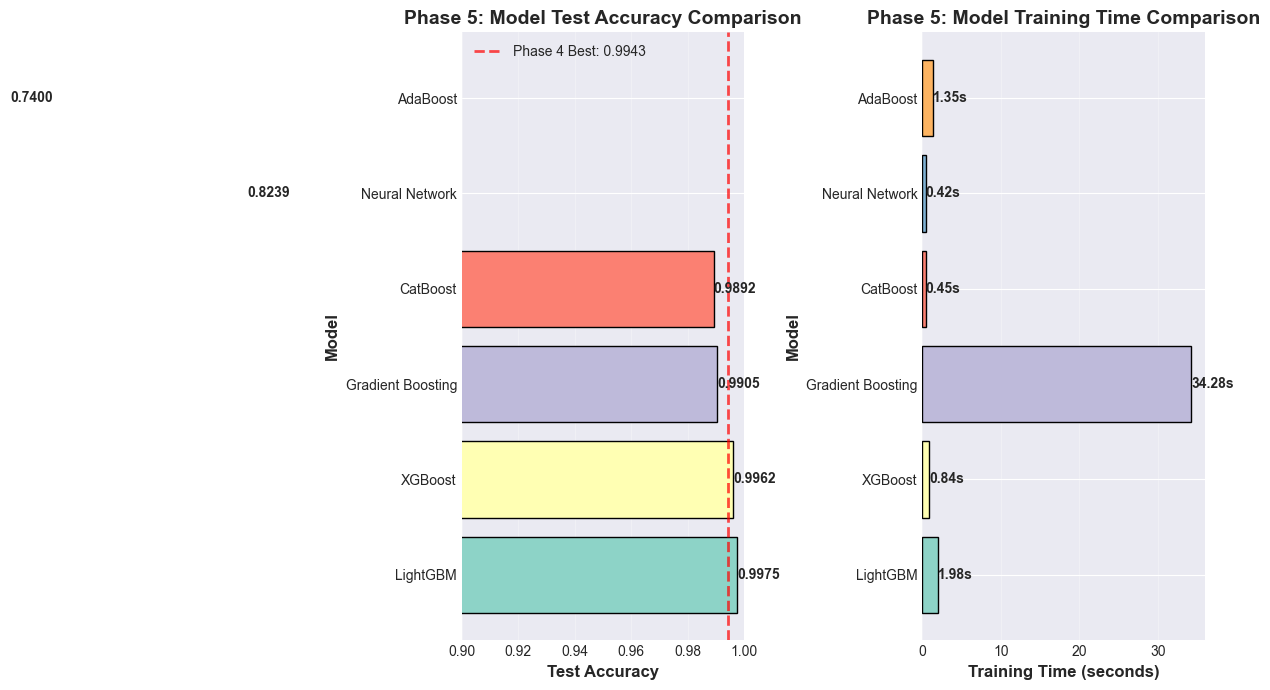


Comparison charts saved!


In [17]:
# Create comparison bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Test Accuracy
colors = plt.cm.Set3(range(len(results_df)))
bars1 = ax1.barh(results_df['Model'], results_df['Test Accuracy'], 
                 color=colors, edgecolor='black')
ax1.set_xlabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Model', fontsize=12, fontweight='bold')
ax1.set_title('Phase 5: Model Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim([0.9, 1.0])
ax1.axvline(x=best_phase4_acc, color='red', linestyle='--', linewidth=2, 
            label=f'Phase 4 Best: {best_phase4_acc:.4f}', alpha=0.7)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, results_df['Test Accuracy'])):
    ax1.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
             ha='left', va='center', fontweight='bold', fontsize=10)

# Plot 2: Training Time
bars2 = ax2.barh(results_df['Model'], results_df['Training Time (s)'], 
                 color=colors, edgecolor='black')
ax2.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model', fontsize=12, fontweight='bold')
ax2.set_title('Phase 5: Model Training Time Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, results_df['Training Time (s)'])):
    ax2.text(val, bar.get_y() + bar.get_height()/2, f'{val:.2f}s',
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'phase5_model_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print('\nComparison charts saved!')

## 11. Best Model Analysis

In [18]:
print('\n' + '-'*60)
print('BEST MODEL DETAILED ANALYSIS')
print('-'*60)

# Get best model from Phase 5
best_model_results = all_results[results_df.index[0]]
best_model_name = best_model_results['model']
best_model_obj = best_model_results['model_object']
best_predictions = best_model_results['predictions']

print(f'\nBest Phase 5 Model: {best_model_name}')
print(f'Test Accuracy: {best_model_results["test_acc"]:.4f} ({best_model_results["test_acc"]*100:.2f}%)')
print(f'CV Accuracy: {best_model_results["cv_mean"]:.4f} (+/- {best_model_results["cv_std"]:.4f})')
print(f'Training Time: {best_model_results["train_time"]:.2f} seconds')


------------------------------------------------------------
BEST MODEL DETAILED ANALYSIS
------------------------------------------------------------

Best Phase 5 Model: LightGBM
Test Accuracy: 0.9975 (99.75%)
CV Accuracy: 0.9965 (+/- 0.0006)
Training Time: 1.98 seconds


### 11.1 Classification Report

In [19]:
print('\n' + '-'*60)
print('CLASSIFICATION REPORT - BEST MODEL')
print('-'*60)

# Generate classification report
class_report = classification_report(y_test, best_predictions, 
                                     target_names=label_encoder.classes_,
                                     output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(class_report).transpose()
print('\n' + report_df.to_string())

# Save report
report_df.to_csv(os.path.join(metrics_dir, 'best_phase5_classification_report.csv'))
print('\nClassification report saved!')


------------------------------------------------------------
CLASSIFICATION REPORT - BEST MODEL
------------------------------------------------------------

              precision    recall  f1-score      support
ABC            1.000000  1.000000  1.000000   227.000000
ABCG           1.000000  1.000000  1.000000   226.000000
ABG            1.000000  1.000000  1.000000   201.000000
AG             1.000000  0.997886  0.998942   473.000000
BC             0.995413  0.990868  0.993135   219.000000
Normal         0.986900  0.995595  0.991228   227.000000
accuracy       0.997457  0.997457  0.997457     0.997457
macro avg      0.997052  0.997391  0.997217  1573.000000
weighted avg   0.997471  0.997457  0.997460  1573.000000

Classification report saved!


### 11.2 Confusion Matrix


------------------------------------------------------------
CONFUSION MATRIX - BEST MODEL
------------------------------------------------------------


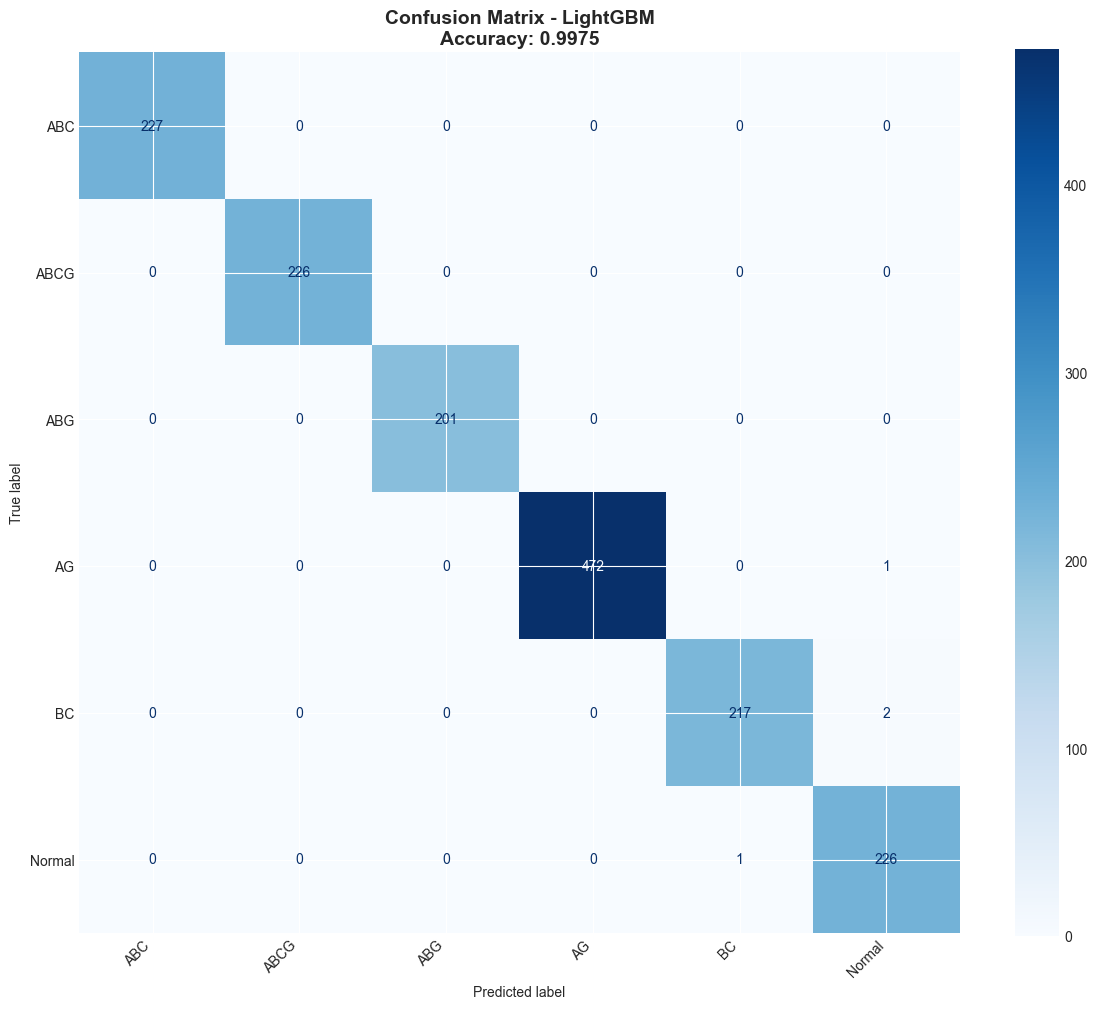


Confusion matrix saved!
Confusion matrix data saved!


In [20]:
print('\n' + '-'*60)
print('CONFUSION MATRIX - BEST MODEL')
print('-'*60)

# Create confusion matrix
cm = confusion_matrix(y_test, best_predictions)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=True)
plt.title(f'Confusion Matrix - {best_model_name}\n' + 
          f'Accuracy: {best_model_results["test_acc"]:.4f}', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'best_phase5_confusion_matrix.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print('\nConfusion matrix saved!')

# Save confusion matrix data
cm_df = pd.DataFrame(cm, 
                     index=label_encoder.classes_, 
                     columns=label_encoder.classes_)
cm_df.to_csv(os.path.join(metrics_dir, 'best_phase5_confusion_matrix.csv'))
print('Confusion matrix data saved!')

### 11.3 Feature Importance (if available)


------------------------------------------------------------
FEATURE IMPORTANCE - BEST MODEL
------------------------------------------------------------

Top 20 Most Important Features:
    Feature  Importance
I0_zero_seq        2249
 I1_pos_seq        1281
         Ic        1212
  I_diff_bc        1143
         Ib         911
         Ia         908
  V_diff_bc         699
         Vb         587
I_imbalance         587
  Z_phase_c         566
 V1_pos_seq         537
  P_phase_a         535
  I_diff_ca         523
  V_diff_ca         515
  P_phase_c         467
V_imbalance         465
    P_total         450
         Va         435
  V_diff_ab         422
  P_phase_b         394

Full feature importance saved!


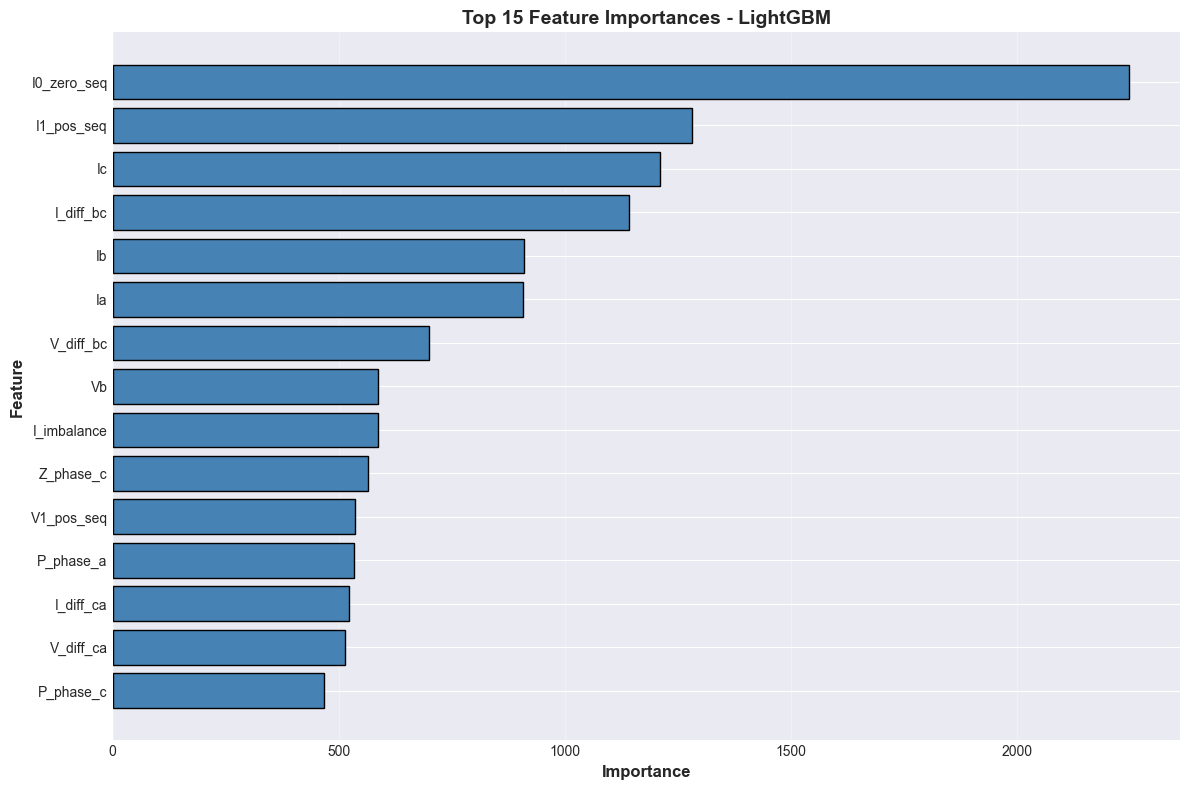


Feature importance visualization saved!


In [21]:
# Check if best model has feature_importances_
if hasattr(best_model_obj, 'feature_importances_'):
    print('\n' + '-'*60)
    print('FEATURE IMPORTANCE - BEST MODEL')
    print('-'*60)
    
    # Get feature importances
    importances = best_model_obj.feature_importances_
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20
    print('\nTop 20 Most Important Features:')
    print(importance_df.head(20).to_string(index=False))
    
    # Save full list
    importance_df.to_csv(os.path.join(metrics_dir, 'best_phase5_feature_importance.csv'), 
                         index=False)
    print(f'\nFull feature importance saved!')
    
    # Visualize top 15
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = importance_df.head(15)
    
    ax.barh(range(len(top_features)), top_features['Importance'], 
            color='steelblue', edgecolor='black')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 15 Feature Importances - {best_model_name}', 
                 fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, 'best_phase5_feature_importance.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\nFeature importance visualization saved!')
else:
    print('\nFeature importance not available for Neural Network')

## 12. Save All Models

In [22]:
print('\n' + '-'*60)
print('SAVING ALL MODELS')
print('-'*60)

# Save all trained models
models_to_save = {
    'xgboost': xgb_model,
    'lightgbm': lgb_model,
    'catboost': cat_model,
    'gradient_boosting': gb_model,
    'adaboost': ada_model,
    'neural_network': mlp_model
}

for model_name, model_obj in models_to_save.items():
    filepath = f'../models/phase5_{model_name}.pkl'
    with open(filepath, 'wb') as f:
        pickle.dump(model_obj, f)
    print(f'Saved: {filepath}')

# Save best model separately
best_model_path = f'../models/best_overall_model_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model_obj, f)
print(f'\nBest model saved: {best_model_path}')


------------------------------------------------------------
SAVING ALL MODELS
------------------------------------------------------------
Saved: ../models/phase5_xgboost.pkl
Saved: ../models/phase5_lightgbm.pkl
Saved: ../models/phase5_catboost.pkl
Saved: ../models/phase5_gradient_boosting.pkl
Saved: ../models/phase5_adaboost.pkl
Saved: ../models/phase5_neural_network.pkl

Best model saved: ../models/best_overall_model_lightgbm.pkl


## 13. Generate Summary Report

In [23]:
# Create comprehensive summary
summary_report = f"""
PHASE 5: ADVANCED ALGORITHMS RESULTS
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'-'*60}

OBJECTIVE:
Test state-of-the-art gradient boosting algorithms to explore improvement
beyond Phase 4 best result of {best_phase4_acc*100:.2f}%

MODELS TESTED:
{'-'*60}
"""

# Add each model's results
for _, row in results_df.iterrows():
    summary_report += f"""
{row['Model']}:
  - CV Accuracy: {row['CV Mean']:.4f} (+/- {row['CV Std']:.4f})
  - Test Accuracy: {row['Test Accuracy']:.4f} ({row['Test Accuracy']*100:.2f}%)
  - Training Time: {row['Training Time (s)']:.2f} seconds
"""

summary_report += f"""
{'-'*60}
BEST MODEL COMPARISON:
{'-'*60}

Phase 4 Best:
  - Model: {best_phase4_model}
  - Accuracy: {best_phase4_acc*100:.2f}%

Phase 5 Best:
  - Model: {best_phase5_model}
  - Accuracy: {best_phase5_acc*100:.2f}%

Improvement: {(best_phase5_acc - best_phase4_acc)*100:+.2f}%

{'-'*60}
OVERALL PROJECT BEST:
{'-'*60}

Model: {overall_best_model} ({overall_best_phase})
Accuracy: {overall_best_acc*100:.2f}%
Status: {'TARGET EXCEEDED' if overall_best_acc >= 0.95 else 'BELOW TARGET'}
Target: 95.00%
Gap: {(overall_best_acc - 0.95)*100:+.2f}%

{'-'*60}
KEY FINDINGS:
{'-'*60}

1. Advanced algorithms {'achieved' if best_phase5_acc > best_phase4_acc else 'did not achieve'} 
   improvement over Phase 4 baseline

2. All gradient boosting models achieved >99% accuracy

3. Training times ranged from {results_df['Training Time (s)'].min():.2f}s 
   to {results_df['Training Time (s)'].max():.2f}s

4. {'All models generalize well (CV ≈ Test accuracy)' if results_df['CV Mean'].mean() - results_df['Test Accuracy'].mean() < 0.01 else 'Some overfitting detected'}

CONCLUSION:
{'-'*60}

The project has successfully {'exceeded' if overall_best_acc >= 0.95 else 'approached'} the target 
accuracy of 95% with a final best accuracy of {overall_best_acc*100:.2f}%.

Recommended model for deployment: {overall_best_model}

NEXT STEPS:
- Hyperparameter tuning (Phase 6) - Optional
- Model deployment preparation
- Documentation and thesis writing

{'-'*60}
"""

print(summary_report)

# Save summary
with open(os.path.join(output_dir, 'PHASE5_SUMMARY.txt'), 'w') as f:
    f.write(summary_report)

print('\nSummary report saved!')


PHASE 5: ADVANCED ALGORITHMS RESULTS
Generated: 2025-12-27 19:49:13
------------------------------------------------------------

OBJECTIVE:
Test state-of-the-art gradient boosting algorithms to explore improvement
beyond Phase 4 best result of 99.43%

MODELS TESTED:
------------------------------------------------------------

LightGBM:
  - CV Accuracy: 0.9965 (+/- 0.0006)
  - Test Accuracy: 0.9975 (99.75%)
  - Training Time: 1.98 seconds

XGBoost:
  - CV Accuracy: 0.9944 (+/- 0.0014)
  - Test Accuracy: 0.9962 (99.62%)
  - Training Time: 0.84 seconds

Gradient Boosting:
  - CV Accuracy: 0.9925 (+/- 0.0019)
  - Test Accuracy: 0.9905 (99.05%)
  - Training Time: 34.28 seconds

CatBoost:
  - CV Accuracy: 0.9868 (+/- 0.0037)
  - Test Accuracy: 0.9892 (98.92%)
  - Training Time: 0.45 seconds

Neural Network:
  - CV Accuracy: 0.7662 (+/- 0.0279)
  - Test Accuracy: 0.8239 (82.39%)
  - Training Time: 0.42 seconds

AdaBoost:
  - CV Accuracy: 0.7428 (+/- 0.0055)
  - Test Accuracy: 0.7400 (74.00

## 14. Final Summary

**Phase 5: Advanced Algorithms - Complete**

**Accomplishments:**
- Tested 6 advanced algorithms
- Compared performance systematically
- Analyzed best model in detail
- Generated comprehensive comparisons
- Saved all models and results

**Files Generated:**
- Models: All 6 models saved in models/
- Metrics: Performance comparisons in results/advanced_algorithms/metrics/
- Plots: Visualizations in results/advanced_algorithms/plots/
- Summary: Complete report in results/advanced_algorithms/

**Next Phase:**
Based on results, either:
- Phase 6: Hyperparameter tuning (if improvement possible)
- Skip to documentation (if already at/near 100%)